In [1]:
import json
import glob
import numpy as np
from sprkana.utils import (
    load_yaml,
    create_dir
)
from typing import List
import matplotlib.pyplot as plt
import re

In [2]:

def load_json_file(fname:str):
    count = None
    bin_start = None
    bin_end = None
    with open(fname, "r") as f:
        for line in f:
            if not line.strip():
                continue  # skip empty lines
            data = json.loads(line)  # each line is a JSON object
            #Bin start
            if bin_start is None:
                bin_start = np.array(data["bin_start"], dtype=float)
            else:
                next_bin_start = np.array(data["bin_start"], dtype=float)
                bin_start = np.append(bin_start,next_bin_start)
            #Bin end
            if bin_end is None:
                bin_end = np.array(data["bin_end"], dtype=float)
            else:
                next_bin_end = np.array(data["bin_end"], dtype=float)
                bin_end = np.append(bin_end,next_bin_end)
            #Counts
            if count is None:
                count = np.array(data["count"], dtype=float)
            else:
                next_count = np.array(data["count"], dtype=float)
                count = np.append(count,next_count)

    return bin_start, bin_end, count


def load_and_merge_histograms(main_dir:str, hist_name:str, extention:str='json'):
    counts = None
    bin_start = None
    bin_end = None

    json_path='/'.join([main_dir,hist_name,'*.'+extention])
    json_files = glob.glob(json_path)

    if len(json_files)==0:
        print(f'Impossible to find json files in path \'{json_path}\'')
        raise ValueError

    for i,file in enumerate(json_files):
        tmp_bin_start, tmp_bin_end, tmp_counts = load_json_file(file)
        if i==0: #First file
            bin_start = tmp_bin_start
            bin_end = tmp_bin_end
            counts = tmp_counts
        else:
            if bin_start is not None:
                assert bin_start != tmp_bin_start, "Value of bin_start doesn't match the next one"
            if bin_end is not None:
                assert bin_end != tmp_bin_end, "Value of bin_end doesn't match the next one"
            counts+=tmp_counts
        
    return bin_start, bin_end, counts

_default_config_basename = 'hist_jets.yaml'
_default_histkey = 'histograms'

def plot(main_dir:str,
        name:str='',
        xlabel=None,
        ylabel=None,
        label=None,
        color=None,
        density=False,
        **kwargs):
    bin_start, bin_end, counts = load_and_merge_histograms(main_dir,name)
    if density:
        counts = counts/np.sum(counts)
    plt.step((bin_start+bin_end)/2., 
             counts, 
             where='post', 
             linewidth=1.5,
             label=label,
             color=color,
             )
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    pass

def plot_hists(
               hist_dict_list:List[dict],
               main_dirs:List[str],
               legend_labels:List[str],
               fig_labels=None,
               figsize=(10, 6),
               leg_loc='best',
               colors=None,
               density=False,
               outdir=None,
               logy=False,
               **kwargs
               ):

    if colors is None:
        colors = ['red','blue','green','orange','pink']

    #Loop over histograms
    for hd in hist_dict_list:
        plt.figure(figsize=figsize)
        print(f"Plotting histogram {hd['name']} with dictionary {hd}...")
        for main_dir,label,color in zip(main_dirs,legend_labels,colors[:len(main_dirs)]): #Loop over directories
            print(f"Making plot from directory '{main_dir}' with label '{label}' and color {color}")
            plot(main_dir,label=label,color=color,density=density,**hd)

        if logy:
            plt.yscale('log')
            # plt.ylim(bottom=1e-6)
        plt.legend(loc=leg_loc, frameon=False)
        if outdir is not None:
            create_dir(outdir)
            plt.savefig(f"{outdir}/{hd['name']}.png", dpi=300, bbox_inches="tight")
        if fig_labels is not None:
            if isinstance(fig_labels, list):
                for i, txt in enumerate(fig_labels):
                    plt.text(0.99, 0.98 - i*0.05, txt, ha='right', va='top', transform=plt.gca().transAxes)
            else:
                plt.text(0.99, 0.98, str(fig_labels), ha='right', va='top', transform=plt.gca().transAxes)
    pass
        



Plotting histogram jet_pt_0 with dictionary {'name': 'jet_pt_0', 'nbins': 50, 'bounds': [0.0, 4000.0], 'col_name': 'jet_pt_0', 'xlabel': 'Leading jet $p_T$ (GeV)'}...
Making plot from directory '../outputs/2025-11-06_emtopo/FS/20250822/HISTS' with label 'Full Simulation (reference)' and color black
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_GeantPionNeutProtPhotEle_StdParam_NoPrePostInclude_PassBackG4MT/20251010/HISTS' with label 'FCS, Geant $\pi$,n,$p^+$,$\gamma$,$e^\pm$ (PassBackG4MT)' and color red
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_Standard/20250822/HISTS' with label 'FCS, Standard' and color blue
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_GeantEGamProtNeut_FCSStandardPions/20251105/HISTS' with label 'FCS, Geant n,$p^+$,$\gamma$,$e^\pm$, FCS Standard Pions' and color orange
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_GeantEGamProtNeut_BSPions/20251105/HISTS' with label 'FCS, Geant n,$p^+$,$\gamma$,$e^\pm

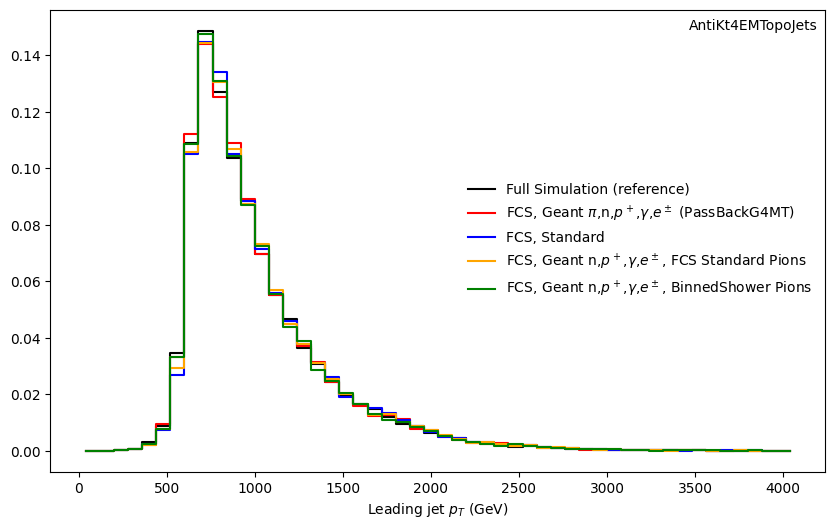

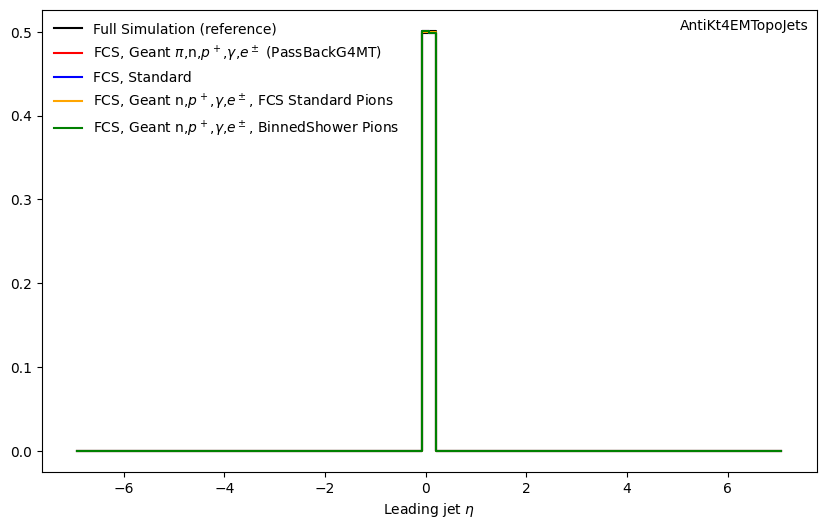

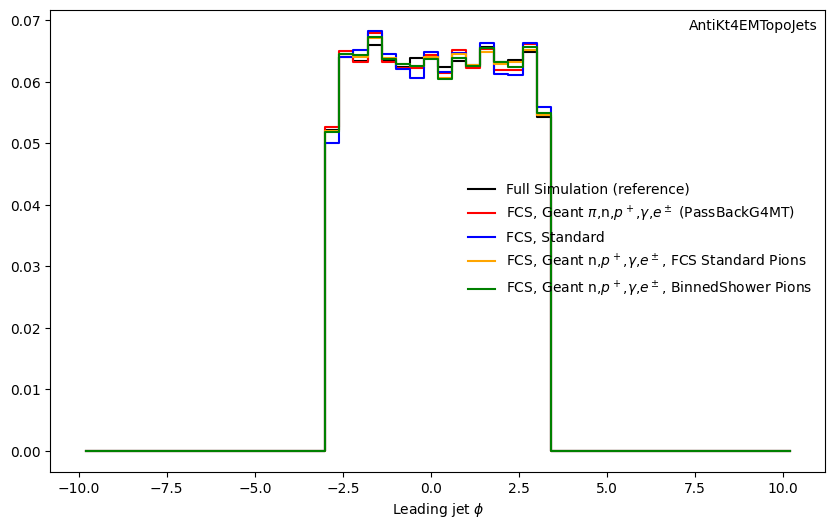

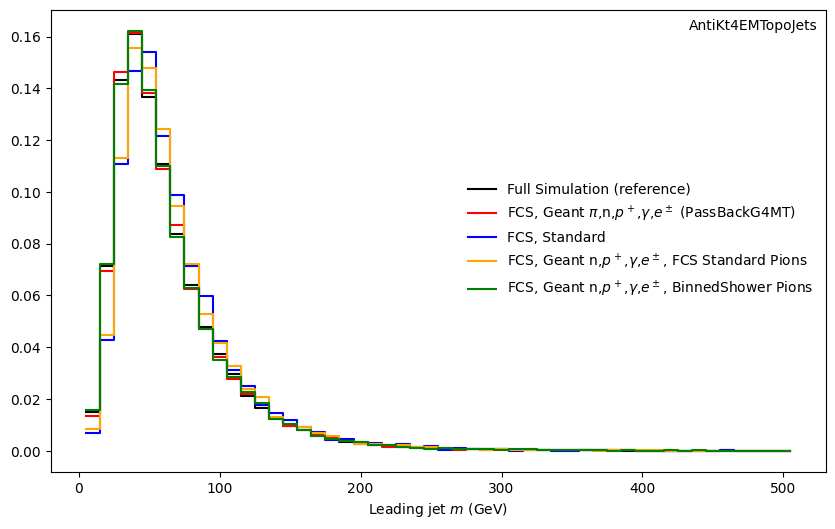

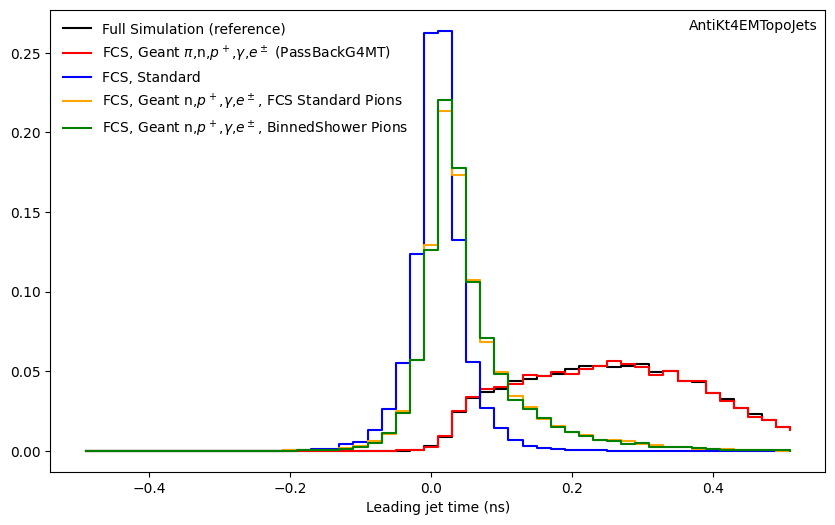

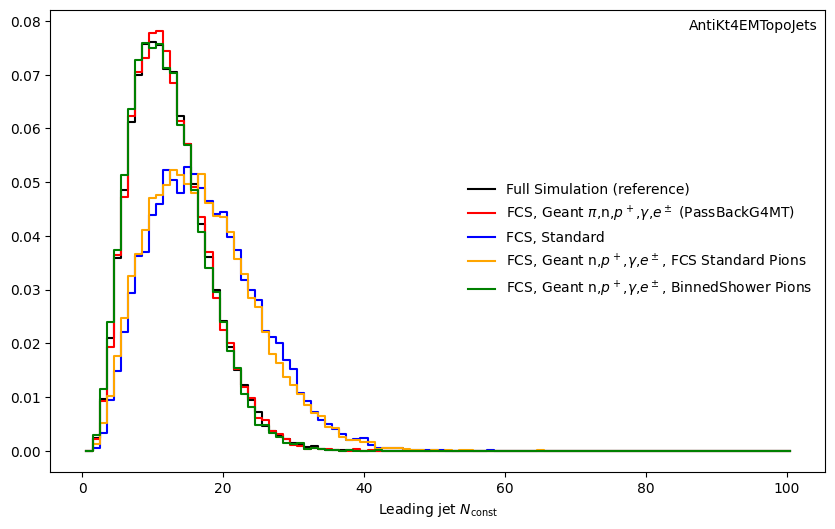

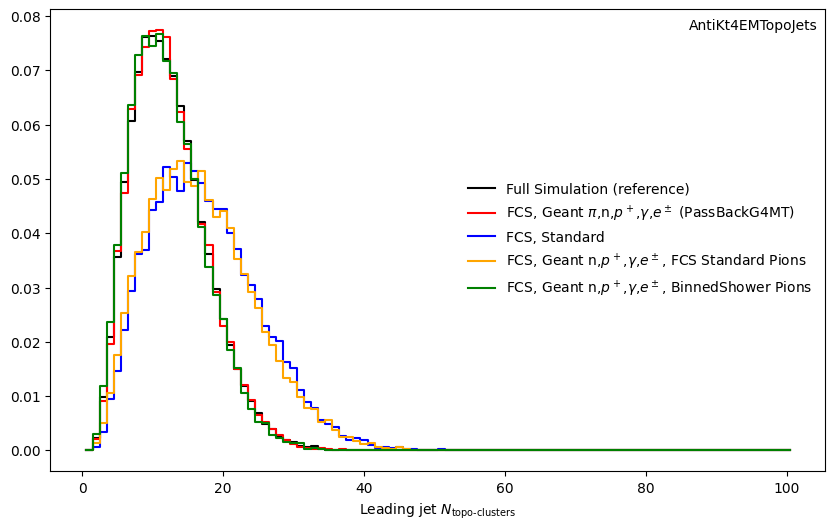

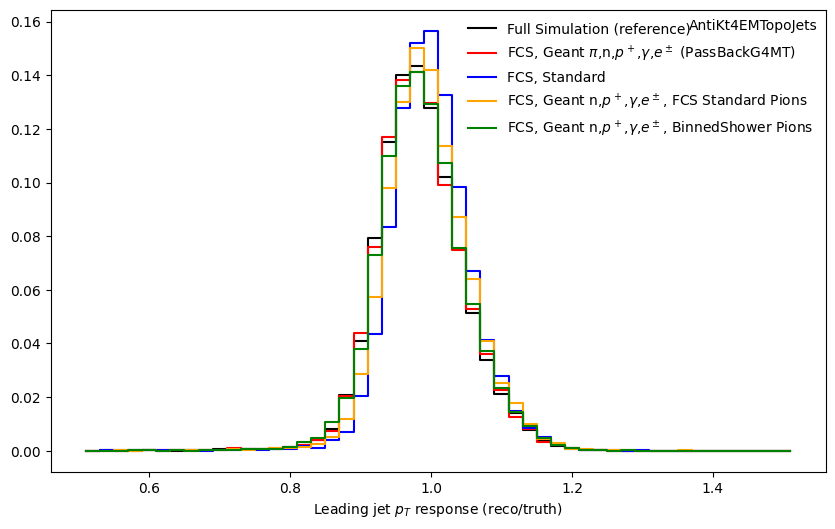

In [12]:
#Plots without residuals
isPFlow=False
legend_labels=[
               'Full Simulation (reference)', 
               'FCS, Geant $\pi$,n,$p^+$,$\gamma$,$e^\pm$ (PassBackG4MT)', 
               'FCS, Standard', 
               'FCS, Geant n,$p^+$,$\gamma$,$e^\pm$, FCS Standard Pions',
               'FCS, Geant n,$p^+$,$\gamma$,$e^\pm$, BinnedShower Pions',
               ]
main_dir=f"../outputs/2025-11-06_em{'pflow' if isPFlow else 'topo'}"
main_dirs = [f'{main_dir}/{sim_type}/HISTS' for sim_type in [
                                                             'FS/20250822',
                                                             "FCS_GeantPionNeutProtPhotEle_StdParam_NoPrePostInclude_PassBackG4MT/20251010",
                                                             'FCS_Standard/20250822', 
                                                             "FCS_GeantEGamProtNeut_FCSStandardPions/20251105",
                                                             "FCS_GeantEGamProtNeut_BSPions/20251105",
                                                             ]]
outputplot_dir = f"{main_dir}/PLOTS"

config_file = '/'.join([main_dirs[0],_default_config_basename])
data = load_yaml(config_file)
hist_dict_list = data[_default_histkey]

plot_hists([entry for entry in hist_dict_list if not re.match(r'jet_d.*',entry['name'])],
           main_dirs,
           legend_labels,
           colors=['black','red','blue','orange','green','pink','purple','brown'],
           outdir=outputplot_dir,
           fig_labels=[f"AntiKt4EM{'PFlow' if isPFlow else 'Topo'}Jets"],
           density=True)

Plotting histogram jet_dpt_0 with dictionary {'name': 'jet_dpt_0', 'nbins': 50, 'bounds': [-500.0, 500.0], 'col_name': 'jet_dpt_0', 'xlabel': 'Leading jet $p_T$ residual (GeV)'}...
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_GeantPionNeutProtPhotEle_StdParam_NoPrePostInclude_PassBackG4MT/20251010/HISTS' with label 'FCS, Geant $\pi$,n,$p^+$,$\gamma$,$e^\pm$ (PassBackG4MT)' and color black
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_Standard/20250822/HISTS' with label 'FCS, Standard' and color red
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_GeantEGamProtNeut_FCSStandardPions/20251105/HISTS' with label 'FCS, Geant n,$p^+$,$\gamma$,$e^\pm$, FCS Standard Pions' and color blue
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_GeantEGamProtNeut_BSPions/20251105/HISTS' with label 'FCS, Geant n,$p^+$,$\gamma$,$e^\pm$, BinnedShower Pions' and color orange


Plotting histogram jet_dphi_0 with dictionary {'name': 'jet_dphi_0', 'nbins': 50, 'bounds': [-0.1, 0.1], 'col_name': 'jet_dphi_0', 'xlabel': 'Leading jet $\\phi$ residual'}...
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_GeantPionNeutProtPhotEle_StdParam_NoPrePostInclude_PassBackG4MT/20251010/HISTS' with label 'FCS, Geant $\pi$,n,$p^+$,$\gamma$,$e^\pm$ (PassBackG4MT)' and color black
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_Standard/20250822/HISTS' with label 'FCS, Standard' and color red
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_GeantEGamProtNeut_FCSStandardPions/20251105/HISTS' with label 'FCS, Geant n,$p^+$,$\gamma$,$e^\pm$, FCS Standard Pions' and color blue
Making plot from directory '../outputs/2025-11-06_emtopo/FCS_GeantEGamProtNeut_BSPions/20251105/HISTS' with label 'FCS, Geant n,$p^+$,$\gamma$,$e^\pm$, BinnedShower Pions' and color orange
Plotting histogram jet_deta_0 with dictionary {'name': 'jet_deta_0', 'nbins': 50, 'bo

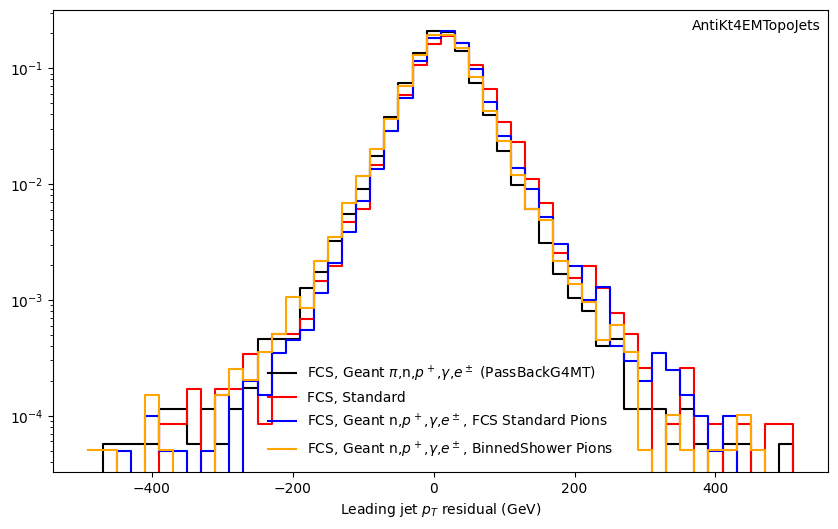

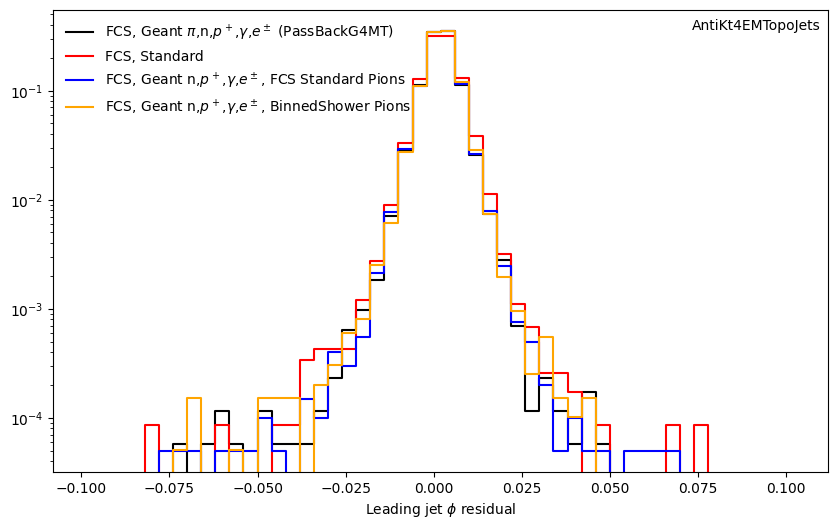

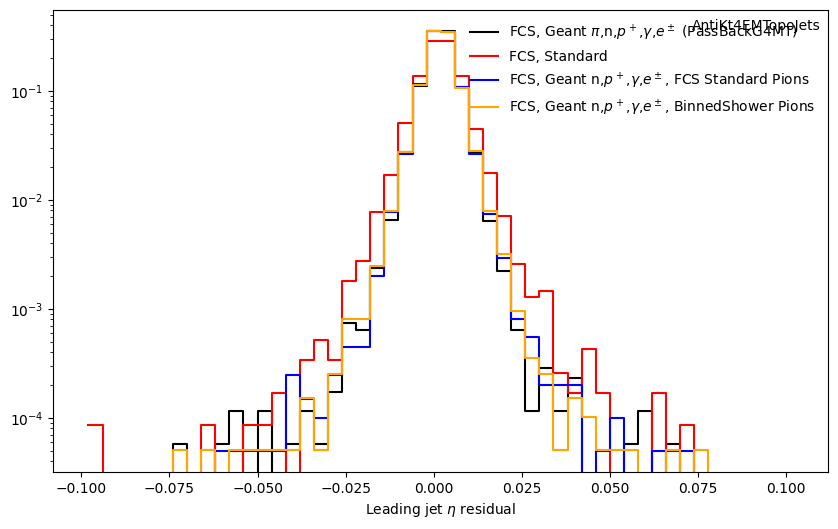

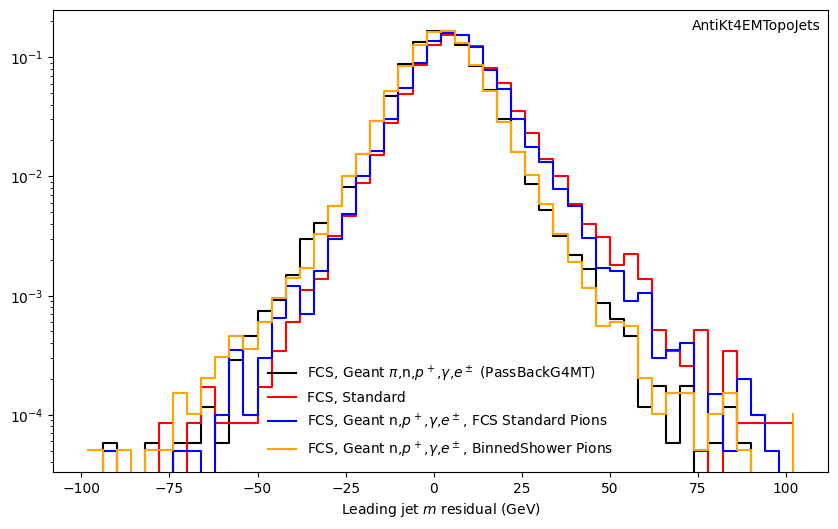

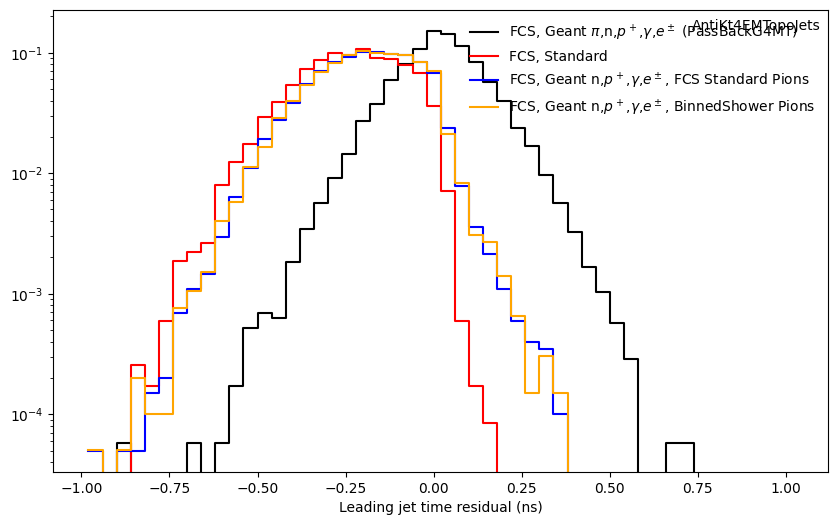

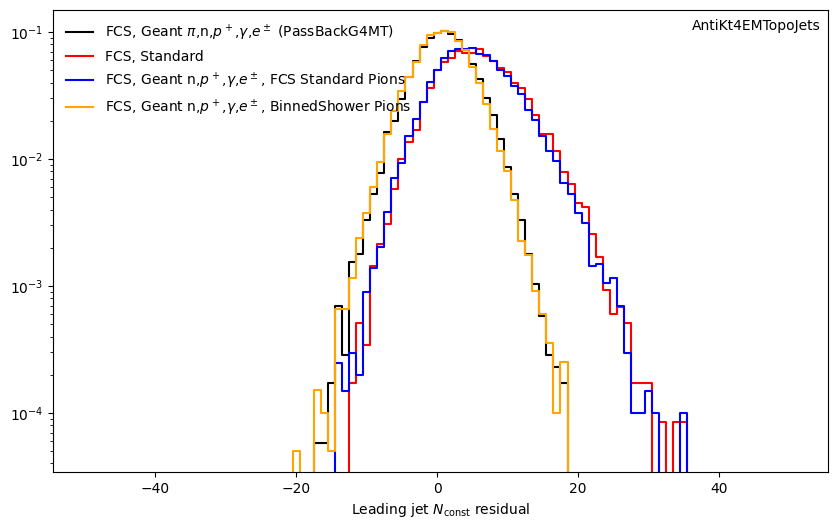

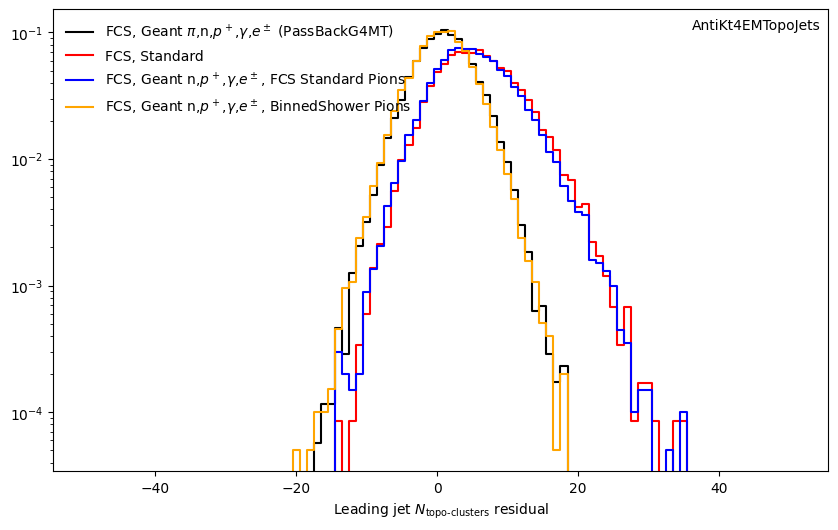

In [13]:
#Residual plots

legend_labels=[
               'FCS, Geant $\pi$,n,$p^+$,$\gamma$,$e^\pm$ (PassBackG4MT)', 
               'FCS, Standard', 
               'FCS, Geant n,$p^+$,$\gamma$,$e^\pm$, FCS Standard Pions',
               'FCS, Geant n,$p^+$,$\gamma$,$e^\pm$, BinnedShower Pions',
               ]
main_dir=f"../outputs/2025-11-06_em{'pflow' if isPFlow else 'topo'}"
main_dirs = [f'{main_dir}/{sim_type}/HISTS' for sim_type in [
                                                             "FCS_GeantPionNeutProtPhotEle_StdParam_NoPrePostInclude_PassBackG4MT/20251010",
                                                             'FCS_Standard/20250822', 
                                                             "FCS_GeantEGamProtNeut_FCSStandardPions/20251105",
                                                             "FCS_GeantEGamProtNeut_BSPions/20251105",
                                                             ]]
outputplot_dir = f"{main_dir}/PLOTS"

config_file = '/'.join([main_dirs[0],_default_config_basename])
data = load_yaml(config_file)
hist_dict_list = data[_default_histkey]

plot_hists([entry for entry in hist_dict_list if re.match(r'jet_d.*',entry['name'])],
           main_dirs,
           legend_labels,
           colors=['black','red','blue','orange','green','pink','purple','brown'],
           outdir=outputplot_dir,
           fig_labels=[f"AntiKt4EM{'PFlow' if isPFlow else 'Topo'}Jets"],
           density=True,
           logy=True
           )